In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model

import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

## Online appendix: BRDD

This is an online appendix to paper: Bayesian causal inference in automotive software engineering

## Setting up the model

In [3]:
def model(X, obs=None):
    
    # Prior for the bias/intercept
    alpha = pyro.sample('alpha', dist.Normal(0., 1.))
    
    # Priors for the regression coeffcients
    beta  = pyro.sample('beta', dist.Normal(torch.zeros(X.shape[1]), 
                                            .5*torch.ones(X.shape[1]))) 
    # Priors for the error term
    epsilon = pyro.sample('epsilon', dist.HalfCauchy(5.))  
    
    with pyro.plate('data'):
        y = pyro.sample('y', dist.Normal(alpha + X.matmul(beta), epsilon), obs=obs)
        
    return y

## Import the data

In [4]:
df = pd.read_csv('data_rdd_input.csv')

Specifying the cut-off point $c$, and compute the dummy variables.

In [5]:
c = 60
df['x-c'] = df['distance_km'] - c

In [6]:
df['(x-c)t'] = (df['distance_km'] - c)*df['treatment']

In [7]:
features = ['x-c', 'treatment', '(x-c)t', 'delta_soc']
target = ['fuel']

In [8]:
df[features].head()

,x-c,treatment,(x-c)t,delta_soc
0,103,1,103,-94.7
1,43,1,43,-92.9
2,24,1,24,-92.6
3,-16,0,0,-91.1
4,-15,0,0,-91.6


In [9]:
df[target].head()

,fuel_l_per_100km
0,5.404663
1,4.749515
2,5.836667
3,2.240455
4,1.465333


Preprocessing the data, and transfer the data format to Pyro tensor.

In [10]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler = MinMaxScaler()

X = MinMaxScaler.fit_transform(df[features])

In [11]:
y = MinMaxScaler.fit_transform(df[target])

In [12]:
X_train = torch.tensor(X).float()
y_train = torch.tensor(y).float()

## The No-U-Turn Sampler in Hamiltonian Monte Carlo

In [13]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=200, num_chains=2)
mcmc.run(X_train, y_train)

In [14]:
mcmc.diagnostics()

{'alpha': OrderedDict([('n_eff', tensor(1465.0980)),
              ('r_hat', tensor(1.0004))]),
 'beta': OrderedDict([('n_eff',
               tensor([ 757.7958, 1591.6656,  770.4050, 2459.9419])),
              ('r_hat', tensor([1.0032, 0.9998, 1.0034, 1.0003]))]),
 'epsilon': OrderedDict([('n_eff', tensor(3239.5928)),
              ('r_hat', tensor(1.0000))]),
 'divergences': {'chain 0': [], 'chain 1': []},
 'acceptance rate': {'chain 0': 0.9985, 'chain 1': 0.999}}

In [18]:
samples = mcmc.get_samples()

## The posterior distribution from NUTS

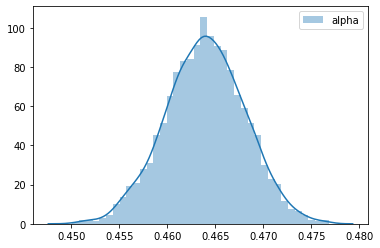

In [19]:
sns.distplot(samples['alpha'].detach().numpy(), label='alpha')
plt.legend()
plt.show()

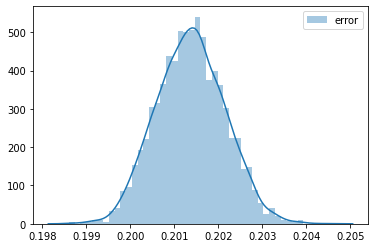

In [20]:
sns.distplot(samples['epsilon'].detach().numpy(), label='error')
plt.legend()
plt.show()

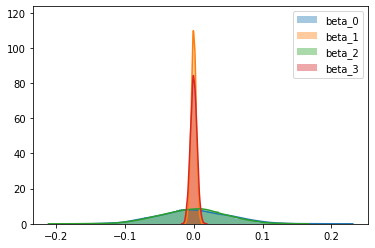

In [21]:
for d in range(X_train.shape[1]):
    sns.distplot(samples['beta'][:, d].detach().numpy())
plt.legend(['beta_%i' %i for i in range(X_train.shape[1])])
plt.show()

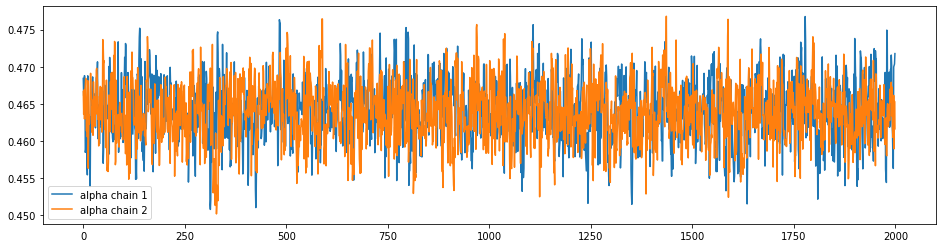

In [22]:
plt.figure(figsize=(16, 4))

plt.plot(np.arange(0, 2000 ,1), 
         samples['alpha'][0:2000].detach().numpy(), 
         label='alpha chain 1')

plt.plot(np.arange(0, 2000 ,1), 
         samples['alpha'][2000:4001].detach().numpy(), 
         label='alpha chain 2')
plt.legend()

plt.show()

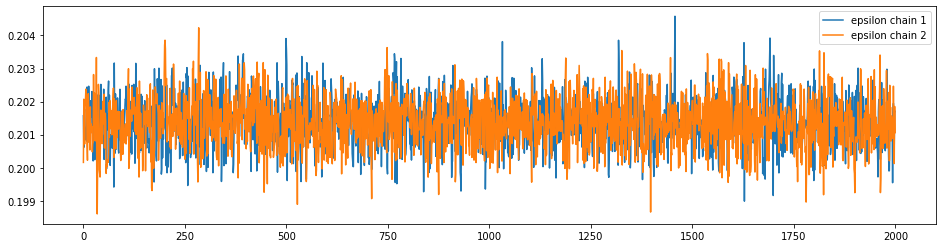

In [23]:
plt.figure(figsize=(16, 4))

plt.plot(np.arange(0, 2000 ,1), 
         samples['epsilon'][0:2000].detach().numpy(), 
         label='epsilon chain 1')

plt.plot(np.arange(0, 2000 ,1), 
         samples['epsilon'][2000:4001].detach().numpy(), 
         label='epsilon chain 2')
plt.legend()

plt.show()

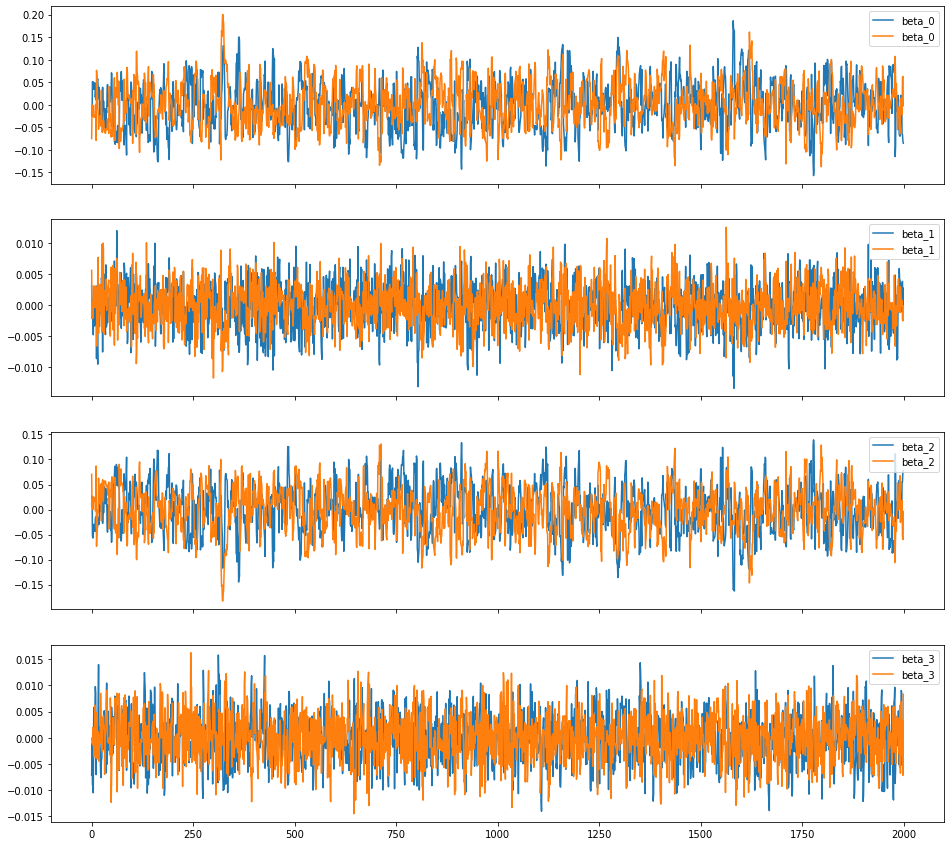

In [24]:
fig, axs = plt.subplots(len(features), 1,
                       figsize=(16, 15),
                       sharex=True)

for i in range(len(features)):
    axs[i].plot(np.arange(0, 2000, 1),
                samples['beta'][0:2000, i].detach().numpy(),
                label='beta_{}'.format(i))
    axs[i].plot(np.arange(0, 2000, 1),
                samples['beta'][2000:4001, i].detach().numpy(),
                label='beta_{}'.format(i))
    
    axs[i].legend(loc='upper right')
    
plt.show()

## Comparison with variational inference

In [25]:
guide = AutoMultivariateNormal(model)

pyro.clear_param_store()

n_steps = 40000

adam_params = {'lr': 0.001}
optimizer = ClippedAdam(adam_params)

elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

for step in range(n_steps):
    elbo = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print('[%d] ELBO: %.1f' %(step, elbo))

[0] ELBO: 90296.4
[1000] ELBO: 57094.0
[2000] ELBO: 15718.3
[3000] ELBO: -1995.4
[4000] ELBO: -5963.7
[5000] ELBO: -6051.3
[6000] ELBO: -6219.9
[7000] ELBO: -6251.7
[8000] ELBO: -6254.6
[9000] ELBO: -6245.7
[10000] ELBO: -6235.8
[11000] ELBO: -6264.5
[12000] ELBO: -6246.0
[13000] ELBO: -6246.4
[14000] ELBO: -6245.7
[15000] ELBO: -6262.1
[16000] ELBO: -6248.1
[17000] ELBO: -6255.7
[18000] ELBO: -6259.7
[19000] ELBO: -6256.1
[20000] ELBO: -6262.4
[21000] ELBO: -6229.1
[22000] ELBO: -6260.5
[23000] ELBO: -6220.0
[24000] ELBO: -6263.0
[25000] ELBO: -6261.7
[26000] ELBO: -6263.3
[27000] ELBO: -6251.3
[28000] ELBO: -6253.5
[29000] ELBO: -6224.0
[30000] ELBO: -6258.2
[31000] ELBO: -6254.3
[32000] ELBO: -6263.0
[33000] ELBO: -6253.1
[34000] ELBO: -6240.0
[35000] ELBO: -6261.0
[36000] ELBO: -6240.6
[37000] ELBO: -6243.0
[38000] ELBO: -6255.9
[39000] ELBO: -6257.2


In [26]:
from pyro.infer import Predictive
predictive = Predictive(model, guide=guide, 
                        num_samples=3000,
                        return_sites=('alpha', 'beta', 'epsilon'))

In [27]:
samples_vi = predictive(X_train, y_train)

## Comparison with variational inference

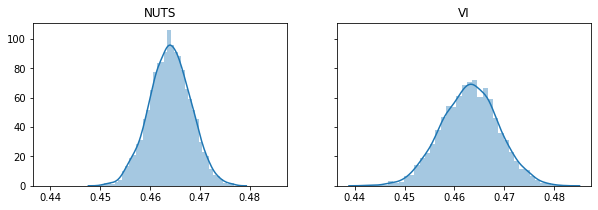

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), 
                        sharey=True, sharex=True)
sns.distplot(samples['alpha'].detach().numpy(), ax=axs[0])
sns.distplot(samples_vi['alpha'].detach().numpy(), ax=axs[1])
axs[0].set_title('NUTS')
axs[1].set_title('VI')
plt.show()

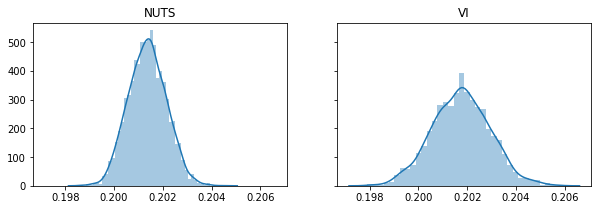

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), 
                        sharey=True, sharex=True)
sns.distplot(samples['epsilon'].detach().numpy(), ax=axs[0])
sns.distplot(samples_vi['epsilon'].detach().numpy(), ax=axs[1])
axs[0].set_title('NUTS')
axs[1].set_title('VI')
plt.show()

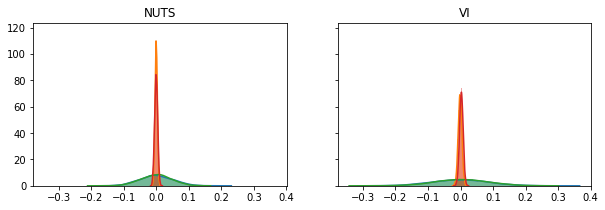

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), 
                        sharey=True, sharex=True)

for d in range(X_train.shape[1]):
    sns.distplot(samples['beta'][:, d].detach().numpy(), ax=axs[0])
    sns.distplot(samples_vi['beta'][:, d].detach().numpy(), ax=axs[1])
axs[0].set_title('NUTS')
axs[1].set_title('VI')
plt.show()